In [ ]:
EMBEDDINGS_BATCH_SIZE = 350

# Dinov2 Embeddings

In [ ]:
import torch
dinov2_vitb14_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg').cuda()
dinov2_vitb14_reg.zero_grad(set_to_none=True)

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

In [ ]:
summary(dinov2_vitg14_reg, (1, 3, 128, 128))

In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image



if "batch" in locals().keys():
  del batch
batch = torch.zeros((EMBEDDINGS_BATCH_SIZE, 350, 350, 3), dtype=torch.float32, device="cuda")


paths = glob.glob("train2014/*.jpg")
print(paths[:10])

ids = []

i = 0
batchnum = 0
for path in paths:
  img_rgb = Image.open(path)
  img_rgb.thumbnail((350, 350), Image.LANCZOS)
  img_rgb = np.array(img_rgb)
  if len(img_rgb.shape) < 3 or img_rgb.shape[2] != 3:
    continue
  
  img_rgb = img_rgb[:, :, ::-1]
  batch[i, :img_rgb.shape[0], :img_rgb.shape[1], :] = torch.from_numpy(img_rgb.copy()).to("cuda")
  ids.append(path.split(".")[0].split("_")[-1])
  i += 1
  if i >= EMBEDDINGS_BATCH_SIZE:
    dinov2_vitb14_reg.eval().cuda()
    with torch.no_grad():
      emb = dinov2_vitb14_reg(batch.transpose(1, 3))
      torch.save((emb, ids), f"dino_embeddings/emb_{batchnum:05d}.pt")
    ids = []
    batch[:, :, :, :] = 0.0
    batchnum += 1
    
    i = 0


print(batch.shape)
print(batchnum)
print(i)


In [ ]:
import gc
gc.collect()
with torch.no_grad():
  torch.cuda.empty_cache()


In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))


In [ ]:
locals().keys()

In [ ]:
del batch

In [ ]:
del dinov2_vitb14_reg

In [ ]:
print(ids)

# 

# GPT-4 Embeddings

In [ ]:
!pip install openai cocotools

In [ ]:
from openai import OpenAI
import os
client = OpenAI(api_key=os.getenv("OAI_KEY"))

In [ ]:
# client.embeddings.create(
#    input="Your text string goes here",
#    model="text-embedding-3-small"
# )

In [ ]:
from pycocotools.coco import COCO

coco_captions = COCO("annotations/captions_train2014.json")

In [ ]:
import glob
import torch
import pandas as pd
import numpy as np
import os


dino_emb_files = glob.glob("dino_embeddings/*.pt")
for file in dino_emb_files:
    batch, ids = torch.load(file)
    ids = [int(id) for id in ids]
    annIds = coco_captions.getAnnIds(imgIds=ids)
    anns = coco_captions.loadAnns(annIds)

    df = pd.DataFrame(anns).groupby(by="image_id")
    captions = []

    for id, group in df:
        caps = group["caption"].to_list()[:5]
        assert len(caps) == 5
        captions.append(zip([id] * 5, caps))

    flatcap = [y for x in captions for (_, y) in x]
    flatid = [y for x in captions for (y, _) in x]
    response = client.embeddings.create(
      input=flatcap,
      model="text-embedding-3-small"
    )
    embeddings = [torch.tensor(x.embedding) for x in response.data]
    embeddings = torch.stack(embeddings)
    text_batch = embeddings.reshape(-1, 5, 1536)

    assert all([a == b for (a, b) in zip(flatid, ids)])

    torch.save((batch, text_batch, ids), f"joint_embeddings/{os.path.basename(file)}")
    
    

    

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))


In [ ]:
locals().keys()

In [ ]:
del batch

In [ ]:
del dinov2_vitb14_reg

In [ ]:
torch.cuda.empty_cache()

In [ ]:
print(ids)

# Bigger Batches

In [ ]:
import glob
import torch

emb_paths = glob.glob("joint_embeddings/*.pt")
emb_groups = [emb_paths[i:i + 10] for i in range(0, len(emb_paths), 10)] 

for group_idx, group in enumerate(emb_groups):
    batch_img, batch_txt = torch.zeros((350*len(group), 768)), torch.zeros((350*len(group), 5, 1536))
    batch_ids = []
    for path_idx, path in enumerate(group):
        minibatch_img, minibatch_txt, minibatch_ids = torch.load(path, map_location="cuda")
        minibatch_ids = [int(id) for id in minibatch_ids]

        batch_ids.extend(minibatch_ids)
        batch_img[path_idx:path_idx+350, :] = minibatch_img
        batch_txt[path_idx:path_idx+350, :, :] = minibatch_txt
    torch.save((batch_img, batch_txt, batch_ids), f"coco_embeddings_3500/batch_{group_idx:05d}.pt")
    print(group_idx)

# FuseMix

In [ ]:
## models
## copy-pasted from paper appendix A

# D x, D y: latent dimension of unimodal encoders
# D s: latent dimension of shared space
# depth x, depth y: number of blocks for each adapter
# expansion factor: expansion factor hyperparameter
# dropout: dropout hyperparameter
from torch import nn

D_x = 768
D_y = 1536
D_s = 768

depth_x, depth_y = 4, 4 # block depth

class Block(nn.Module):
    def __init__(self, dim, expansion_factor=4, dropout=0.6):
        super().__init__()
        self.fn = nn.Sequential(
            nn.Linear(dim, int(expansion_factor * dim)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(expansion_factor * dim), dim),
        )
        self.ln = nn.LayerNorm(dim)
        
    def forward(self, x):
        return x + self.fn(self.ln(x))

In [ ]:
h_X = nn.Sequential(
*[Block(D_x) for _ in range(depth_x)],
nn.LayerNorm(D_x),
nn.Linear(D_x, D_s),
)
h_Y = nn.Sequential(
*[Block(D_y) for _ in range(depth_y)],
nn.LayerNorm(D_y),
nn.Linear(D_y, D_s),
)
h_X.to("cuda")
h_Y.to("cuda")

In [ ]:
summary(h_X, (7000, D_x))

In [ ]:
summary(h_Y, (7000, D_y))

## Training

In [ ]:
import torch
all_img_emb = torch.zeros((82600, 768), dtype=torch.float32, device="cuda")
all_txt_emb = torch.zeros((82600, 5, 1536), dtype=torch.float32, device="cuda")
all_ids = []

In [ ]:
import glob
import torch

emb_paths = glob.glob("coco_embeddings_3500/*.pt")

for path_idx, path in enumerate(emb_paths):
    batch, text_batch, ids = torch.load(path, map_location="cuda")
    all_img_emb[path_idx*3500:path_idx*3500+batch.shape[0], :] = batch
    all_txt_emb[path_idx*3500:path_idx*3500+batch.shape[0], :, :] = text_batch
    all_ids.extend(ids)
    print(batch.shape[0])

del batch
del text_batch
del ids

In [ ]:
import random
import numpy as np

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

pass

In [ ]:
B = 7000
STEPS = 100000

In [ ]:
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import torch
import time

t = nn.Parameter(torch.ones([], requires_grad=True).to("cuda"))

params = list(h_X.parameters()) + list(h_Y.parameters()) + [t]
optimizer = torch.optim.Adam(params, lr=1e-4)

print_every = 1000
last_time = 0

for i in range(STEPS):
    ind = torch.randint(0, 82600, (2*B,))
    text_ind = torch.randint(0, 5, (2*B,))
    
    z_x = all_img_emb[ind, :]
    z_y = all_txt_emb[ind, text_ind, :]
    
    z_x1, z_x2 = torch.chunk(z_x, 2) # B x D x
    z_y1, z_y2 = torch.chunk(z_y, 2) # B x D y
    
    lam = random.random()
    
    z_x = lam * z_x1 + (1 - lam) * z_x2
    z_y = lam * z_y1 + (1 - lam) * z_y2
    
    # joint space and normalize
    s_x = F.normalize(h_X(z_x)) # B x D s
    s_y = F.normalize(h_Y(z_y)) # B x D s
    
    # pairwise cosine similarity w/ temperature
    logits_xy = (s_x @ s_y.T) * t.exp() # B x B
    logits_yx = (s_y @ s_x.T) * t.exp() # B x B

    logits_xy.to("cuda")
    logits_yx.to("cuda")
    
    # symmetric alignment loss
    labels = torch.arange(B, device="cuda")
    loss_xy = F.cross_entropy(logits_xy, labels)
    loss_yx = F.cross_entropy(logits_yx, labels)
    loss = (loss_xy + loss_yx) / 2
    
    # optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % print_every == 0:
        print(i, time.time() - last_time)

In [ ]:
torch.save((h_X, h_Y, t), "params_1.pt")

# Inference

In [1]:
!pip install scikit-image openai
pass

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
import torch
all_img_emb = torch.zeros((82600, 768), dtype=torch.float32, device="cuda")
all_txt_emb = torch.zeros((82600, 5, 1536), dtype=torch.float32, device="cuda")
all_ids = []

In [4]:
import glob
import torch

emb_paths = glob.glob("coco_embeddings_3500/*.pt")

for path_idx, path in enumerate(emb_paths):
    batch, text_batch, ids = torch.load(path, map_location="cuda")
    all_img_emb[path_idx*3500:path_idx*3500+batch.shape[0], :] = batch
    all_txt_emb[path_idx*3500:path_idx*3500+batch.shape[0], :, :] = text_batch
    all_ids.extend(ids)

del batch
del text_batch
del ids

In [5]:
import torch
response = openai.embeddings.create(
    input="a desk with a blue notepad, pens, and index cards, next to which a feline lays rest",
    model="text-embedding-3-small"
)
sample_emb = torch.tensor(response.data[0].embedding).unsqueeze(0)

In [6]:
sample_emb.shape

torch.Size([1, 1536])

In [30]:
from train import Block

checkpoint = torch.load("model_first_success/step_10000.pt")
h_X, h_Y, t = checkpoint["model"]
h_X.eval()
h_Y.eval()

pass

In [32]:
losses = checkpoint["loss_history"]
print(losses[::1000])

[5.992067337036133, 4.18135929107666, 2.4395692348480225, 0.5977368950843811, 0.5241668224334717, 0.5079351663589478, 0.5023902654647827, 0.49952930212020874, 0.4985337555408478, 0.49804291129112244, 0.4977583587169647]


In [10]:
import torch.nn.functional as F
sample_text_in_shared_space = F.normalize(h_Y(sample_emb.to("cuda")), dim=-1)

In [11]:
if "all_img_emb_in_shared_space" in locals().keys():
    del all_img_emb_in_shared_space
    
all_img_emb_in_shared_space = F.normalize(h_X(all_img_emb), dim=-1)
print(all_img_emb_in_shared_space.shape)

torch.Size([82600, 768])


In [22]:
import torch.nn.functional as F

# similarity = F.cosine_similarity(sample_text_in_shared_space.repeat(82600, 1), all_img_emb_in_shared_space)
xy = (sample_text_in_shared_space @ all_img_emb_in_shared_space.T)
yx = (all_img_emb_in_shared_space @ sample_text_in_shared_space.T)
similarity = (xy + yx.T)/2
similarity = similarity.squeeze()
print(similarity.shape)

torch.Size([82600])


In [23]:
cos, ind = torch.topk(similarity, 10)
cosb, indb = torch.topk(-similarity, 10)

cos = cos.tolist() + cosb.tolist()
ind = ind.tolist() + indb.tolist()

In [24]:
import skimage.io as io
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

print(cos, ind)
coco = COCO("annotations/captions_train2014.json")
sample_imgs = coco.loadImgs([all_ids[a] for a in ind])
sample_imgs = [img["coco_url"] for img in sample_imgs]


[0.8820565342903137, 0.880887508392334, 0.8806695938110352, 0.8746085166931152, 0.8740597367286682, 0.8717302680015564, 0.8706973195075989, 0.8691588044166565, 0.8679375648498535, 0.8675845265388489, 0.26997578144073486, 0.25777944922447205, 0.2383834719657898, 0.2344694882631302, 0.22400404512882233, 0.2210250049829483, 0.22034919261932373, 0.2202773243188858, 0.21833497285842896, 0.21808604896068573] [73815, 179, 24610, 73724, 66547, 59551, 3502, 70280, 7064, 17698, 80734, 49230, 24838, 3532, 17729, 38506, 42084, 3679, 17559, 21119]
loading annotations into memory...
Done (t=0.46s)
creating index...
index created!


COSINE: 0.88206


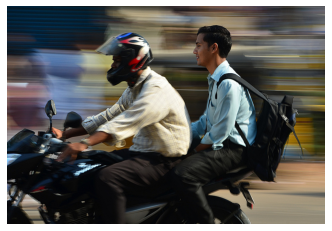

COSINE: 0.88089


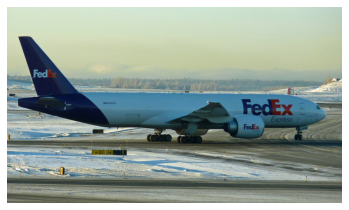

COSINE: 0.88067


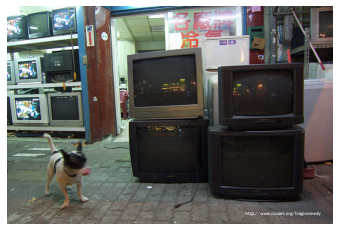

COSINE: 0.87461


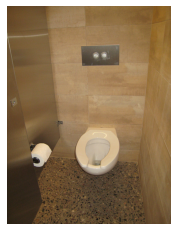

COSINE: 0.87406


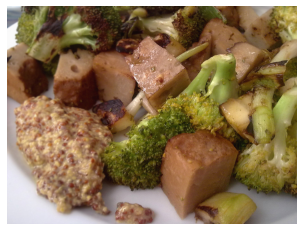

COSINE: 0.87173


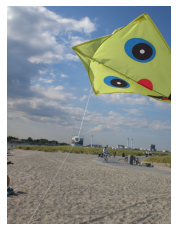

COSINE: 0.87070


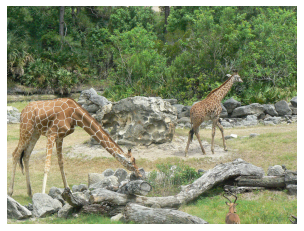

COSINE: 0.86916


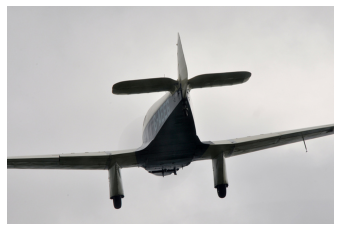

COSINE: 0.86794


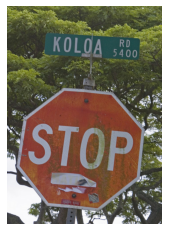

COSINE: 0.86758


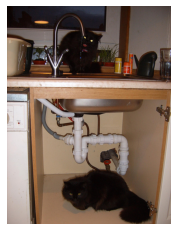

COSINE: 0.26998


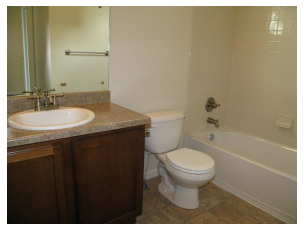

COSINE: 0.25778


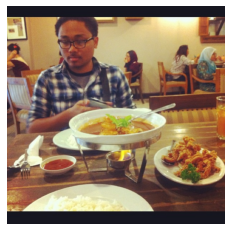

COSINE: 0.23838


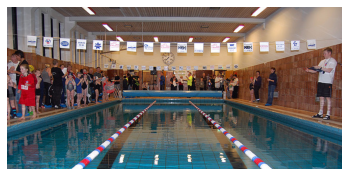

COSINE: 0.23447


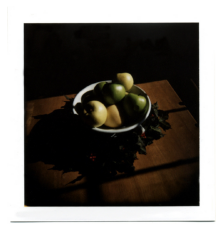

COSINE: 0.22400


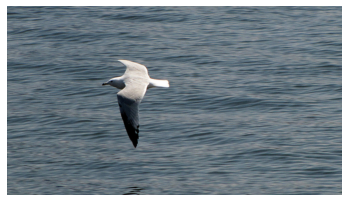

COSINE: 0.22103


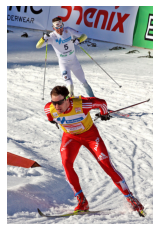

COSINE: 0.22035


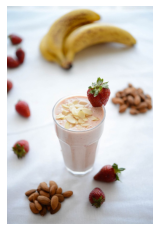

COSINE: 0.22028


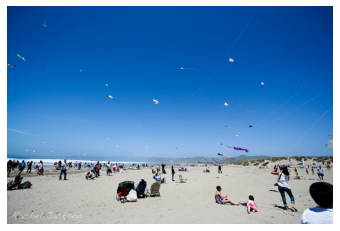

COSINE: 0.21833


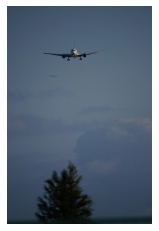

COSINE: 0.21809


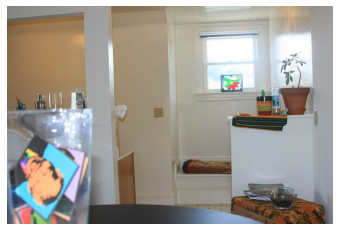

In [25]:
for score, url in zip(cos + [0], sample_imgs):
    I = io.imread(url)
    print(f"COSINE: {score:0.05f}")
    plt.axis('off')
    plt.imshow(I)
    plt.show()

In [27]:
print(similarity[all_ids.index(389996)])

tensor(0.5066, device='cuda:0', grad_fn=<SelectBackward0>)


In [16]:
print(389996 in all_ids)

True
